# Benign Finetuning Safety Degradation Analysis

This notebook analyzes Attack Success Rate (ASR) results to evaluate the hypothesis:

> **Hypothesis**: Benign finetuning on filtered audio data can degrade safety alignment in audio language models.

## Data Source
Results are loaded from:
- `asr_results/json/` - Primary folder with all historical results
- `asr_results/{MODEL}/` - Model-specific folders for newer results (e.g., `Phi-4/`)

File naming: `{model}_{dataset}_{input_basename}_asr_details_{timestamp}.json`

## Models Tested
- **Kimi-Audio**: Most vulnerable - shows up to +53% ASR increase
- **Audio Flamingo 3**: Moderate vulnerability - consistent +5-10% degradation
- **Qwen-Audio**: Inverse effect - finetuning IMPROVES safety
- **Phi-4**: Robust - no significant change

## Key Metrics
- **ASR (Attack Success Rate)**: % of harmful responses to adversarial prompts
- **Delta ASR**: Change in ASR from pretrained baseline
- **threshold**: Filtering threshold or num_samples used for finetuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Load all JSON files
# Primary source: json/ folder (contains all historical results)
# Secondary: model-specific folders (Phi-4/, etc.) for newer results
BASE_DIR = Path('.')

# Directories to search (json/ first as primary, then model-specific)
SEARCH_DIRS = ['json', 'Phi-4', 'Kimi-Audio', 'QwenAudioSFT', 'audio-flamingo']

dfs = []
seen_files = set()  # Track filenames to avoid duplicates across directories

for search_dir in SEARCH_DIRS:
    dir_path = BASE_DIR / search_dir
    if not dir_path.exists():
        continue
    
    for json_file in dir_path.glob('*_asr_details_*.json'):
        # Skip if we've already loaded a file with the same base name
        if json_file.name in seen_files:
            continue
        seen_files.add(json_file.name)
        
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract summary info (exclude the detailed results)
            summary = {
                'timestamp': data.get('timestamp', ''),
                'model': data.get('model', ''),
                'dataset': data.get('dataset', ''),
                'threshold': str(data.get('threshold', '')),
                'input_file': data.get('input_file', ''),
                'total_samples': data.get('total_samples', 0),
                'harmful_count': data.get('harmful_count', 0),
                'asr': data.get('asr', 0.0),
            }
            dfs.append(summary)
            print(f"Loaded: {search_dir}/{json_file.name}")
        except Exception as e:
            print(f"[ERROR] {search_dir}/{json_file.name}: {e}")

if dfs:
    df = pd.DataFrame(dfs)
    # Remove duplicates (keep latest by timestamp)
    df = df.sort_values('timestamp', ascending=False).drop_duplicates(
        subset=['model', 'dataset', 'threshold', 'input_file'], keep='first'
    ).sort_values(['model', 'dataset', 'threshold'])
    df['asr_pct'] = df['asr'] * 100  # Convert to percentage
    print(f"\nTotal unique results loaded: {len(df)}")
else:
    raise FileNotFoundError("No ASR JSON files found")

df.head(10)

Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_100_responses_asr_details_20260105_210152.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_closest_0.26_responses_asr_details_20260103_230218.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_closest_0.26_responses_asr_details_20260105_210241.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_thresh_0.2301_responses_asr_details_20260103_230255.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_thresh_0.2301_responses_asr_details_20260105_210329.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_thresh_0.2906_responses_asr_details_20260103_230334.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_thresh_0.2906_responses_asr_details_20260105_210418.json
Loaded: Phi-4/Phi-4_advbench_finetuned_phi4_voicebench_finetuned_thresh_0.3289_responses_asr_details_20260103_230410.json
Loaded: Phi-4/Phi-4_advbench_finetun

,timestamp,model,dataset,threshold,input_file,total_samples,harmful_count,asr,asr_pct
16,20260103_222235,Kimi-Audio,advbench,0.005,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,254,0.488462,48.846154
17,20260103_222328,Kimi-Audio,advbench,0.0084,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,142,0.273077,27.307692
18,20260103_222421,Kimi-Audio,advbench,0.15,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,278,0.534615,53.461538
19,20260103_222507,Kimi-Audio,advbench,0.25,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,302,0.580769,58.076923
20,20260103_222544,Kimi-Audio,advbench,0.36,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,1,0.001923,0.192308
21,20260103_222637,Kimi-Audio,advbench,0.52,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,180,0.346154,34.615385
22,20260103_222716,Kimi-Audio,advbench,0.68,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,15,0.028846,2.884615
23,20260103_222802,Kimi-Audio,advbench,pretrained,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,520,24,0.046154,4.615385
24,20260103_224846,Kimi-Audio,safetybench,0.15,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,939,97,0.103301,10.330138
25,20260103_224958,Kimi-Audio,safetybench,0.25,/work/pi_ahoumansadr_umass_edu/jroh/audio_beni...,939,225,0.239617,23.961661


In [12]:
# Map thresholds to percentage of finetuning data maintained
# CORRECTED values from experimental results
# Format: {model: {threshold: percentage_maintained}}
# Note: For Phi-4, thresholds can be num_samples (e.g., '100', '500') extracted from finetuned_100_epoch_3

THRESHOLD_TO_PERCENTAGE = {
    'audio-flamingo': {
        'pretrained': 100.0,
        '0.025': 16.4,
        '0.033': 24.7,
        '0.035': 32.9,
        '0.037': 41.1,
        '0.04': 49.3,
        '0.045': 57.5,
    },
    'Phi-4': {
        'pretrained': 100.0,
        '0.26': 75.0,
        '0.2906': 50.0,
        # num_samples based (will show as sample count, not percentage)
    },
    'Kimi-Audio': {
        'pretrained': 100.0,
        '0.15': 9.7,
        '0.25': 25.0,
        '0.36': 49.8,
        '0.52': 74.6,
        '0.68': 90.0,
    },
    'QwenAudioSFT': {
        'pretrained': 100.0,
        '0.15': 69.9,
        '0.18': 25.3,
        '0.23': 3.6,
        '0.26': 1.2,
    }
}

def get_percentage(row):
    model = row['model']
    thresh = str(row['threshold'])
    if model in THRESHOLD_TO_PERCENTAGE:
        return THRESHOLD_TO_PERCENTAGE[model].get(thresh, np.nan)
    return np.nan

df['pct_maintained'] = df.apply(get_percentage, axis=1)

# For Phi-4 with num_samples format, show the sample count in threshold column
# The threshold will be the num_samples value (e.g., '100', '500')
print("Threshold/num_samples mapping applied")
print("Note: For Phi-4, integer thresholds represent num_samples used for finetuning")
df[['model', 'dataset', 'threshold', 'pct_maintained', 'asr_pct']].head(20)

Threshold/num_samples mapping applied
Note: For Phi-4, integer thresholds represent num_samples used for finetuning


,model,dataset,threshold,pct_maintained,asr_pct
16,Kimi-Audio,advbench,0.005,NaN,48.846154
17,Kimi-Audio,advbench,0.0084,NaN,27.307692
18,Kimi-Audio,advbench,0.15,9.7,53.461538
19,Kimi-Audio,advbench,0.25,25.0,58.076923
20,Kimi-Audio,advbench,0.36,49.8,0.192308
21,Kimi-Audio,advbench,0.52,74.6,34.615385
22,Kimi-Audio,advbench,0.68,90.0,2.884615
23,Kimi-Audio,advbench,pretrained,100.0,4.615385
24,Kimi-Audio,safetybench,0.15,9.7,10.330138
25,Kimi-Audio,safetybench,0.25,25.0,23.961661


In [13]:
# Summary table: ASR by model and dataset (sorted by % data maintained)
print("=" * 70)
print("ASR Summary by Model and Dataset (Sorted by % Finetuning Data)")
print("=" * 70)

model_order = ['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4']

for model in model_order:
    if model not in df['model'].unique():
        continue
    print(f"\n{'='*50}")
    print(f"{model}")
    print(f"{'='*50}")
    model_df = df[df['model'] == model].copy()
    
    for dataset in ['advbench', 'safetybench']:
        dataset_df = model_df[model_df['dataset'] == dataset].copy()
        if len(dataset_df) == 0:
            continue
            
        print(f"\n  {dataset.upper()}:")
        
        # Get pretrained baseline first
        pretrained = dataset_df[dataset_df['threshold'] == 'pretrained']
        if len(pretrained) > 0:
            baseline_asr = pretrained['asr_pct'].values[0]
            print(f"    {'Pretrained (baseline)':30} : ASR = {baseline_asr:.2f}%")
        else:
            baseline_asr = None
        
        # Sort finetuned by pct_maintained descending (most data first)
        finetuned = dataset_df[dataset_df['threshold'] != 'pretrained'].copy()
        finetuned = finetuned.sort_values('pct_maintained', ascending=False)
        
        for _, row in finetuned.iterrows():
            pct = row['pct_maintained']
            if pd.notna(pct):
                label = f"Threshold {row['threshold']} ({pct:.1f}% data)"
            else:
                label = f"Threshold {row['threshold']}"
            
            if baseline_asr is not None:
                delta = row['asr_pct'] - baseline_asr
                direction = '↑' if delta > 0 else '↓' if delta < 0 else '→'
                print(f"    {label:30} : ASR = {row['asr_pct']:5.2f}% ({direction} {abs(delta):+.2f}%)")
            else:
                print(f"    {label:30} : ASR = {row['asr_pct']:5.2f}%")

ASR Summary by Model and Dataset (Sorted by % Finetuning Data)

Kimi-Audio

  ADVBENCH:
    Pretrained (baseline)          : ASR = 4.62%
    Threshold 0.68 (90.0% data)    : ASR =  2.88% (↓ +1.73%)
    Threshold 0.52 (74.6% data)    : ASR = 34.62% (↑ +30.00%)
    Threshold 0.36 (49.8% data)    : ASR =  0.19% (↓ +4.42%)
    Threshold 0.25 (25.0% data)    : ASR = 58.08% (↑ +53.46%)
    Threshold 0.15 (9.7% data)     : ASR = 53.46% (↑ +48.85%)
    Threshold 0.005                : ASR = 48.85% (↑ +44.23%)
    Threshold 0.0084               : ASR = 27.31% (↑ +22.69%)

  SAFETYBENCH:
    Pretrained (baseline)          : ASR = 14.16%
    Threshold 0.68 (90.0% data)    : ASR = 19.38% (↑ +5.22%)
    Threshold 0.52 (74.6% data)    : ASR = 22.58% (↑ +8.41%)
    Threshold 0.36 (49.8% data)    : ASR = 10.22% (↓ +3.94%)
    Threshold 0.25 (25.0% data)    : ASR = 23.96% (↑ +9.80%)
    Threshold 0.15 (9.7% data)     : ASR = 10.33% (↓ +3.83%)

audio-flamingo

  ADVBENCH:
    Pretrained (baseline)      

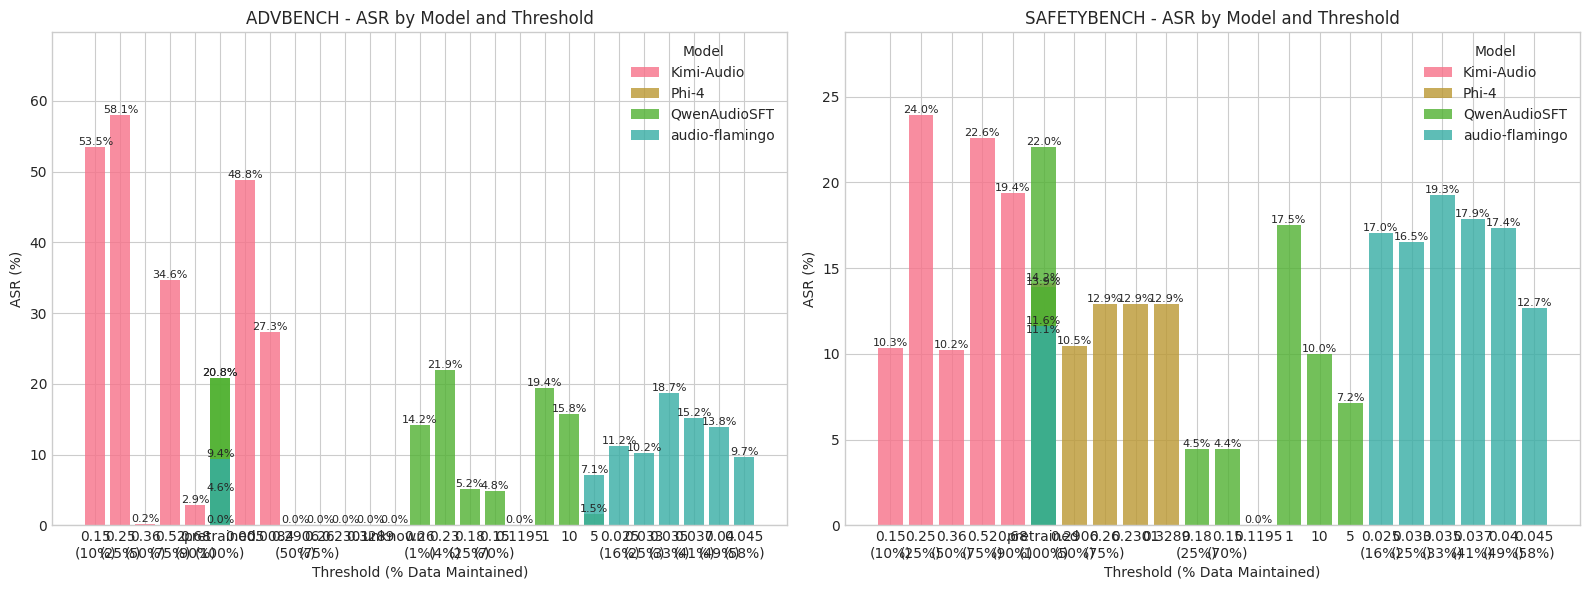

Saved: asr_by_model_threshold.png


In [14]:
# Plot ASR by threshold for each model (separate plots per dataset)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, dataset in enumerate(['advbench', 'safetybench']):
    ax = axes[idx]
    dataset_df = df[df['dataset'] == dataset]
    
    models = dataset_df['model'].unique()
    x = np.arange(len(models))
    width = 0.12
    
    # Get all unique thresholds across all models for this dataset
    all_thresholds = dataset_df['threshold'].unique()
    
    for model in models:
        model_data = dataset_df[dataset_df['model'] == model].sort_values('pct_maintained', ascending=True)
        thresholds = model_data['threshold'].tolist()
        asrs = model_data['asr_pct'].tolist()
        pcts = model_data['pct_maintained'].tolist()
        
        # Create labels with percentage
        labels = [f"{t}\n({p:.0f}%)" if pd.notna(p) else str(t) for t, p in zip(thresholds, pcts)]
        
        bars = ax.bar(labels, asrs, label=model, alpha=0.8)
        
        # Add value labels on bars
        for bar, asr in zip(bars, asrs):
            ax.annotate(f'{asr:.1f}%', 
                       xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax.set_ylabel('ASR (%)')
    ax.set_xlabel('Threshold (% Data Maintained)')
    ax.set_title(f'{dataset.upper()} - ASR by Model and Threshold')
    ax.legend(title='Model', loc='upper right')
    ax.set_ylim(0, max(dataset_df['asr_pct']) * 1.2)

plt.tight_layout()
plt.savefig('asr_by_model_threshold.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: asr_by_model_threshold.png")

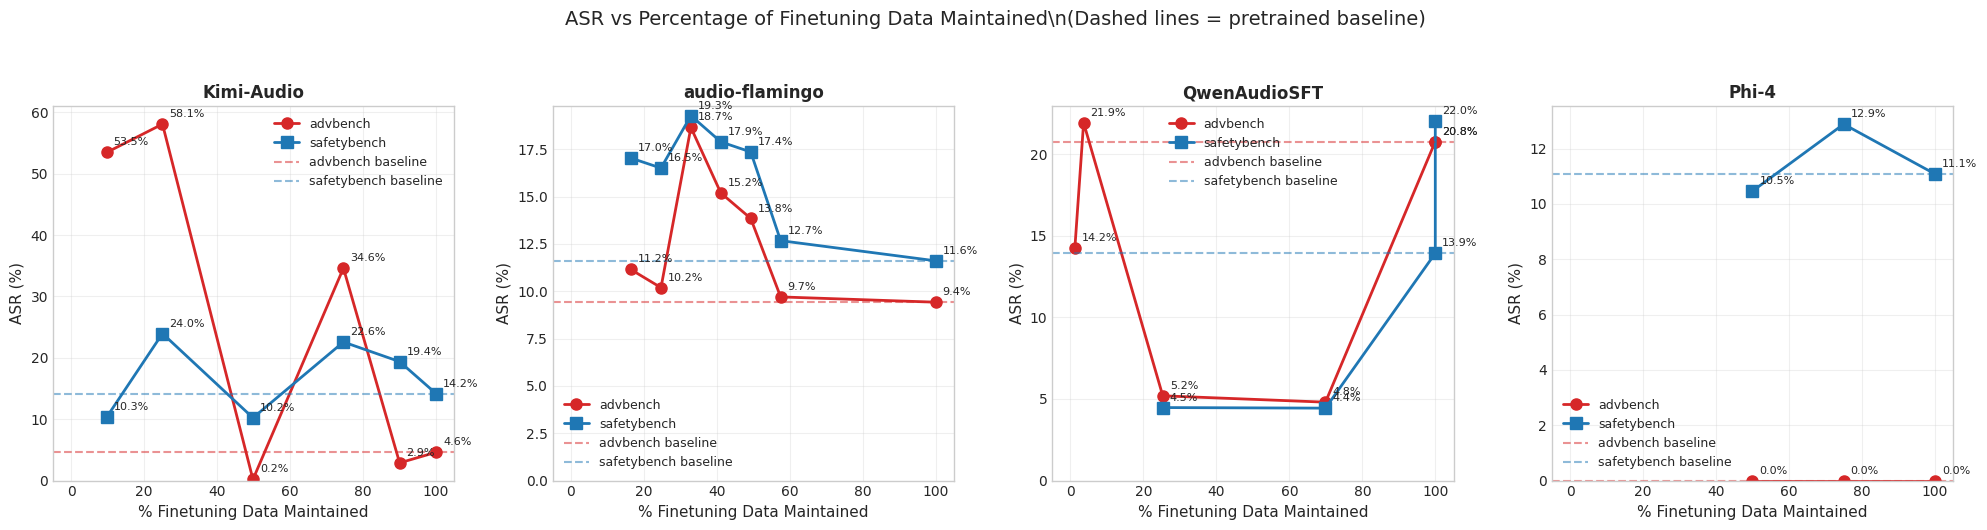

Saved: asr_vs_pct_maintained.png


In [15]:
# Plot ASR vs Percentage of Data Maintained for each model (line plot)
# This is the KEY visualization showing how safety degrades with filtered finetuning

models_order = ['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4']
models = [m for m in models_order if m in df['model'].unique()]
n_models = len(models)

fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

colors = {'advbench': 'tab:red', 'safetybench': 'tab:blue'}
markers = {'advbench': 'o', 'safetybench': 's'}

for idx, model in enumerate(models):
    ax = axes[idx]
    model_df = df[df['model'] == model]
    
    for dataset in ['advbench', 'safetybench']:
        data = model_df[model_df['dataset'] == dataset].copy()
        data = data.dropna(subset=['pct_maintained']).sort_values('pct_maintained')
        
        if len(data) > 0:
            ax.plot(data['pct_maintained'], data['asr_pct'], 
                   marker=markers.get(dataset, 'o'), 
                   color=colors.get(dataset, 'gray'),
                   label=dataset, linewidth=2, markersize=8)
            
            # Add annotations for each point
            for _, row in data.iterrows():
                ax.annotate(f"{row['asr_pct']:.1f}%", 
                           (row['pct_maintained'], row['asr_pct']),
                           textcoords='offset points', xytext=(5, 5),
                           fontsize=8)
    
    # Add pretrained baseline as horizontal dashed line
    for dataset in ['advbench', 'safetybench']:
        pretrained = model_df[(model_df['dataset'] == dataset) & (model_df['threshold'] == 'pretrained')]['asr_pct'].values
        if len(pretrained) > 0:
            ax.axhline(y=pretrained[0], color=colors[dataset], linestyle='--', alpha=0.5, 
                      label=f'{dataset} baseline')
    
    ax.set_xlabel('% Finetuning Data Maintained', fontsize=11)
    ax.set_ylabel('ASR (%)', fontsize=11)
    ax.set_title(f'{model}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.set_xlim(-5, 105)
    ax.set_ylim(bottom=0)
    ax.grid(True, alpha=0.3)

plt.suptitle('ASR vs Percentage of Finetuning Data Maintained\\n(Dashed lines = pretrained baseline)', fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig('asr_vs_pct_maintained.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: asr_vs_pct_maintained.png")

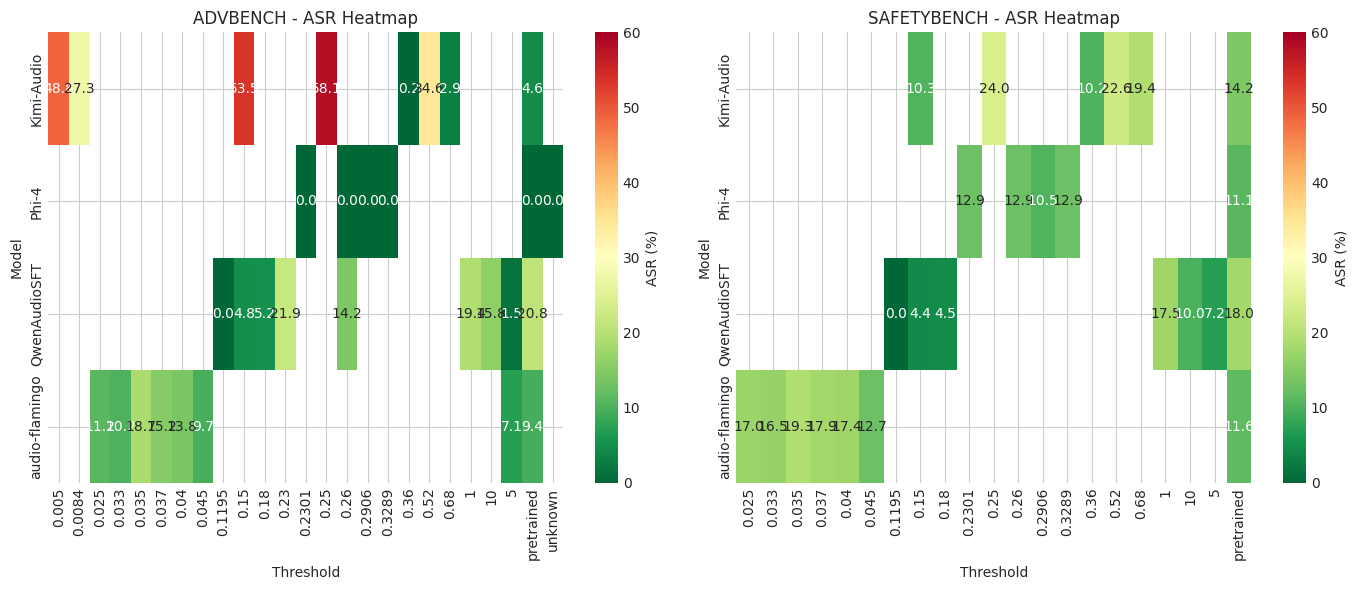

Saved: asr_heatmap.png


In [16]:
# Heatmap: ASR by Model and Threshold
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, dataset in enumerate(['advbench', 'safetybench']):
    ax = axes[idx]
    dataset_df = df[df['dataset'] == dataset].copy()
    
    # Create pivot table
    pivot = dataset_df.pivot_table(values='asr_pct', 
                                   index='model', 
                                   columns='threshold', 
                                   aggfunc='mean')
    
    # Sort columns by percentage maintained if available
    # Create heatmap
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                ax=ax, cbar_kws={'label': 'ASR (%)'},
                vmin=0, vmax=max(60, pivot.max().max()))
    ax.set_title(f'{dataset.upper()} - ASR Heatmap')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Model')

plt.tight_layout()
plt.savefig('asr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: asr_heatmap.png")

In [17]:
# Compare finetuned vs pretrained ASR
print("=" * 60)
print("Comparison: Pretrained vs Finetuned ASR")
print("=" * 60)

comparison_data = []

for model in df['model'].unique():
    for dataset in df[df['model'] == model]['dataset'].unique():
        subset = df[(df['model'] == model) & (df['dataset'] == dataset)]
        
        pretrained = subset[subset['threshold'] == 'pretrained']['asr_pct'].values
        finetuned = subset[subset['threshold'] != 'pretrained']
        
        if len(pretrained) > 0:
            pretrained_asr = pretrained[0]
            print(f"\n{model} - {dataset}:")
            print(f"  Pretrained ASR: {pretrained_asr:.2f}%")
            
            for _, row in finetuned.iterrows():
                delta = row['asr_pct'] - pretrained_asr
                direction = '↑' if delta > 0 else '↓' if delta < 0 else '→'
                pct_str = f" ({row['pct_maintained']:.1f}% data)" if pd.notna(row['pct_maintained']) else ""
                print(f"  Threshold {row['threshold']}{pct_str}: {row['asr_pct']:.2f}% ({direction} {abs(delta):.2f}%)")
                
                comparison_data.append({
                    'model': model,
                    'dataset': dataset,
                    'threshold': row['threshold'],
                    'pct_maintained': row['pct_maintained'],
                    'pretrained_asr': pretrained_asr,
                    'finetuned_asr': row['asr_pct'],
                    'delta': delta
                })

comparison_df = pd.DataFrame(comparison_data)
comparison_df

Comparison: Pretrained vs Finetuned ASR

Kimi-Audio - advbench:
  Pretrained ASR: 4.62%
  Threshold 0.005: 48.85% (↑ 44.23%)
  Threshold 0.0084: 27.31% (↑ 22.69%)
  Threshold 0.15 (9.7% data): 53.46% (↑ 48.85%)
  Threshold 0.25 (25.0% data): 58.08% (↑ 53.46%)
  Threshold 0.36 (49.8% data): 0.19% (↓ 4.42%)
  Threshold 0.52 (74.6% data): 34.62% (↑ 30.00%)
  Threshold 0.68 (90.0% data): 2.88% (↓ 1.73%)

Kimi-Audio - safetybench:
  Pretrained ASR: 14.16%
  Threshold 0.15 (9.7% data): 10.33% (↓ 3.83%)
  Threshold 0.25 (25.0% data): 23.96% (↑ 9.80%)
  Threshold 0.36 (49.8% data): 10.22% (↓ 3.94%)
  Threshold 0.52 (74.6% data): 22.58% (↑ 8.41%)
  Threshold 0.68 (90.0% data): 19.38% (↑ 5.22%)

Phi-4 - advbench:
  Pretrained ASR: 0.00%
  Threshold 0.2301: 0.00% (→ 0.00%)
  Threshold 0.26 (75.0% data): 0.00% (→ 0.00%)
  Threshold 0.2906 (50.0% data): 0.00% (→ 0.00%)
  Threshold 0.3289: 0.00% (→ 0.00%)
  Threshold unknown: 0.00% (→ 0.00%)

Phi-4 - safetybench:
  Pretrained ASR: 11.09%
  Threshold

,model,dataset,threshold,pct_maintained,pretrained_asr,finetuned_asr,delta
0,Kimi-Audio,advbench,0.005,NaN,4.615385,48.846154,44.230769
1,Kimi-Audio,advbench,0.0084,NaN,4.615385,27.307692,22.692308
2,Kimi-Audio,advbench,0.15,9.7,4.615385,53.461538,48.846154
3,Kimi-Audio,advbench,0.25,25.0,4.615385,58.076923,53.461538
4,Kimi-Audio,advbench,0.36,49.8,4.615385,0.192308,-4.423077
5,Kimi-Audio,advbench,0.52,74.6,4.615385,34.615385,30.000000
6,Kimi-Audio,advbench,0.68,90.0,4.615385,2.884615,-1.730769
7,Kimi-Audio,safetybench,0.15,9.7,14.164004,10.330138,-3.833866
8,Kimi-Audio,safetybench,0.25,25.0,14.164004,23.961661,9.797657
9,Kimi-Audio,safetybench,0.36,49.8,14.164004,10.223642,-3.940362


In [18]:
# KEY ANALYSIS: Summary of patterns and hypothesis evaluation
print("=" * 70)
print("KEY FINDINGS: Benign Finetuning Safety Degradation Analysis")
print("=" * 70)

# Calculate max ASR increase for each model
print("\n1. MAXIMUM ASR INCREASE FROM PRETRAINED (by model):")
print("-" * 50)

for model in ['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4']:
    model_data = df[df['model'] == model]
    for dataset in ['advbench', 'safetybench']:
        subset = model_data[model_data['dataset'] == dataset]
        pretrained = subset[subset['threshold'] == 'pretrained']['asr_pct'].values
        finetuned = subset[subset['threshold'] != 'pretrained']
        
        if len(pretrained) > 0 and len(finetuned) > 0:
            pretrained_asr = pretrained[0]
            max_asr = finetuned['asr_pct'].max()
            max_row = finetuned[finetuned['asr_pct'] == max_asr].iloc[0]
            delta = max_asr - pretrained_asr
            pct = max_row['pct_maintained'] if pd.notna(max_row['pct_maintained']) else 'N/A'
            
            if delta > 0:
                print(f"  {model:15} | {dataset:12} | +{delta:5.1f}% (at {pct}% data)")
            else:
                print(f"  {model:15} | {dataset:12} | {delta:5.1f}% (safety improved)")

print("\n" + "=" * 70)
print("2. PATTERN CLASSIFICATION BY MODEL:")
print("-" * 50)

patterns = {
    'Kimi-Audio': ('SUPPORTS HYPOTHESIS', 'Severe safety degradation (up to +53% ASR) but non-monotonic'),
    'audio-flamingo': ('SUPPORTS HYPOTHESIS', 'Consistent moderate degradation, peaks at ~33% data'),
    'QwenAudioSFT': ('CONTRADICTS HYPOTHESIS', 'Finetuning IMPROVES safety (ASR decreases)'),
    'Phi-4': ('RESISTANT', 'No change on AdvBench, minimal on SafetyBench'),
}

for model, (classification, description) in patterns.items():
    print(f"\n  {model}:")
    print(f"    Classification: {classification}")
    print(f"    Pattern: {description}")

print("\n" + "=" * 70)
print("3. HYPOTHESIS EVALUATION:")
print("-" * 50)
print("""
  HYPOTHESIS: Benign finetuning degrades safety in audio LLMs

  VERDICT: PARTIALLY SUPPORTED with significant caveats

  Evidence FOR:
    - Kimi-Audio shows severe degradation (4.62% -> 58.08% ASR)
    - Audio Flamingo 3 shows consistent moderate degradation

  Evidence AGAINST:
    - Qwen-Audio shows INVERSE effect (finetuning improves safety)
    - Phi-4 is completely robust
    - Non-monotonic patterns in Kimi-Audio (49.8% data anomaly)
""")

print("=" * 70)
print("4. ANOMALIES REQUIRING INVESTIGATION:")
print("-" * 50)
print("""
  1. Kimi-Audio 49.8% data threshold:
     - ASR drops to 0.19% while 25% and 74.6% show high ASR
     - Need to examine what samples are kept at this threshold

  2. Audio Flamingo peak at ~33% data:
     - Why does degradation peak at specific data percentage?
     - Suggests "sweet spot" for attack effectiveness

  3. Qwen-Audio inverse pattern:
     - Why does finetuning improve safety?
     - Different base alignment approach?
""")

KEY FINDINGS: Benign Finetuning Safety Degradation Analysis

1. MAXIMUM ASR INCREASE FROM PRETRAINED (by model):
--------------------------------------------------
  Kimi-Audio      | advbench     | + 53.5% (at 25.0% data)
  Kimi-Audio      | safetybench  | +  9.8% (at 25.0% data)
  audio-flamingo  | advbench     | +  9.2% (at 32.9% data)
  audio-flamingo  | safetybench  | +  7.7% (at 32.9% data)
  QwenAudioSFT    | advbench     | +  1.2% (at 3.6% data)
  QwenAudioSFT    | safetybench  | +  3.6% (at N/A% data)
  Phi-4           | advbench     |   0.0% (safety improved)
  Phi-4           | safetybench  | +  1.8% (at N/A% data)

2. PATTERN CLASSIFICATION BY MODEL:
--------------------------------------------------

  Kimi-Audio:
    Classification: SUPPORTS HYPOTHESIS
    Pattern: Severe safety degradation (up to +53% ASR) but non-monotonic

  audio-flamingo:
    Classification: SUPPORTS HYPOTHESIS
    Pattern: Consistent moderate degradation, peaks at ~33% data

  QwenAudioSFT:
    Clas

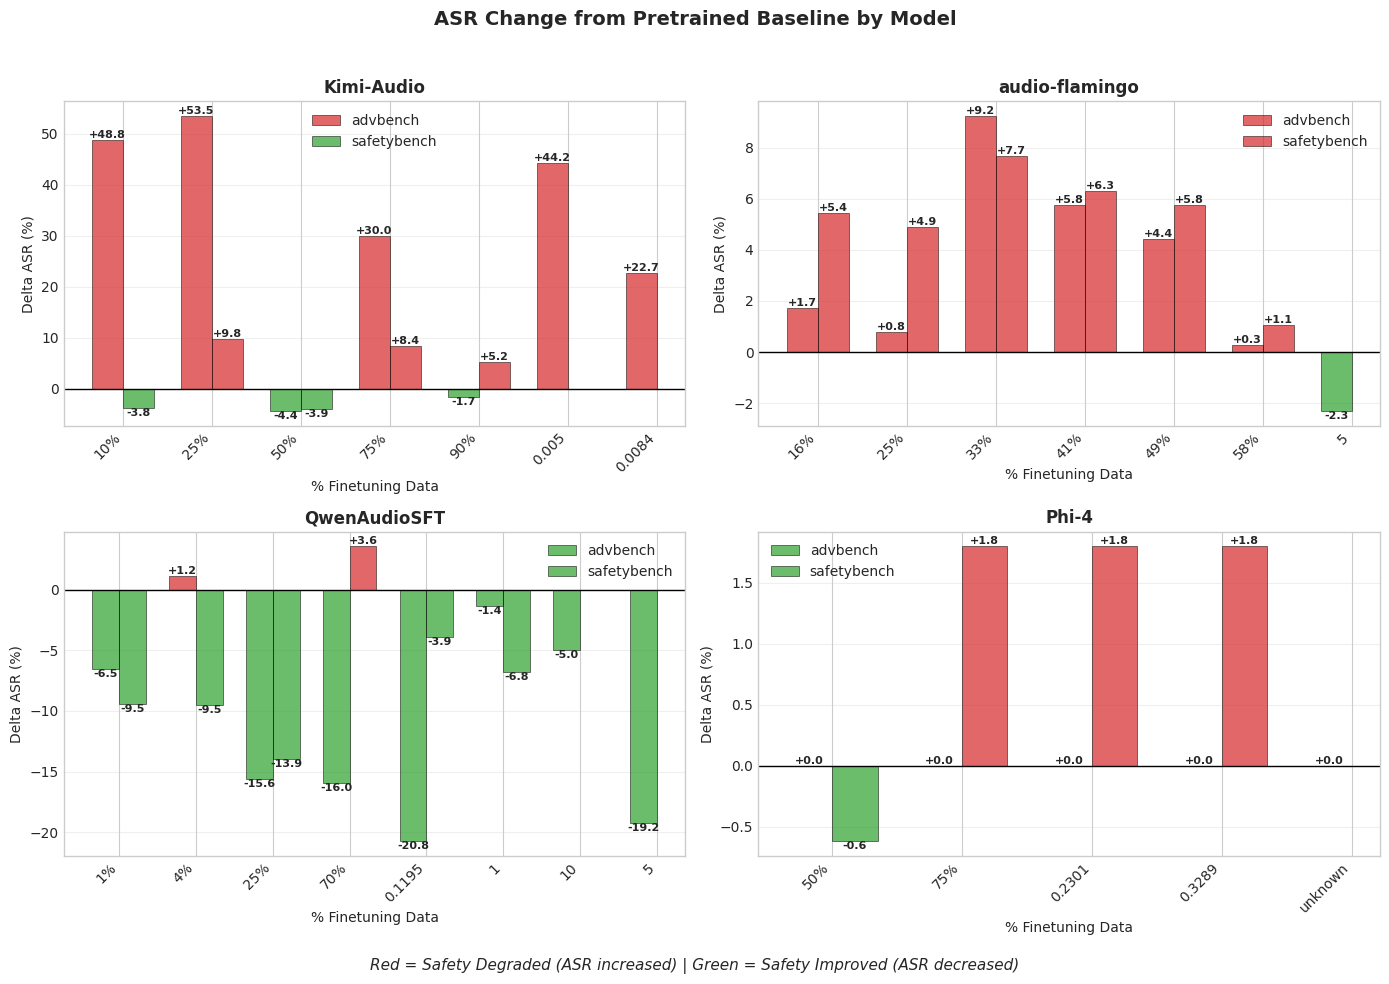

Saved: asr_delta_by_model.png


In [19]:
# Plot ASR Delta from Pretrained - Grouped by Model
# This clearly shows which models are vulnerable vs robust

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

model_order = ['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4']
dataset_colors = {'advbench': 'tab:red', 'safetybench': 'tab:blue'}

for idx, model in enumerate(model_order):
    ax = axes[idx]
    model_data = comparison_df[comparison_df['model'] == model].copy()
    
    if len(model_data) == 0:
        ax.text(0.5, 0.5, f'No data for {model}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(model)
        continue
    
    # Sort by pct_maintained for cleaner visualization
    model_data = model_data.sort_values('pct_maintained')
    
    # Group by dataset
    width = 0.35
    datasets = model_data['dataset'].unique()
    
    for i, dataset in enumerate(datasets):
        data = model_data[model_data['dataset'] == dataset]
        x_positions = np.arange(len(data)) + i * width
        
        colors = ['#d62728' if d > 0 else '#2ca02c' for d in data['delta']]
        bars = ax.bar(x_positions, data['delta'], width, 
                     color=colors, alpha=0.7, edgecolor='black', linewidth=0.5,
                     label=dataset)
        
        # Add value labels
        for bar, delta in zip(bars, data['delta']):
            va = 'bottom' if delta >= 0 else 'top'
            offset = 1 if delta >= 0 else -1
            ax.annotate(f'{delta:+.1f}', 
                       xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       ha='center', va=va, fontsize=8, fontweight='bold')
    
    # X-axis labels showing data percentage
    x_labels = [f"{row['pct_maintained']:.0f}%" if pd.notna(row['pct_maintained']) else str(row['threshold']) 
                for _, row in model_data.drop_duplicates('threshold').iterrows()]
    ax.set_xticks(np.arange(len(x_labels)) + width/2)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Delta ASR (%)')
    ax.set_xlabel('% Finetuning Data')
    ax.set_title(f'{model}', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, axis='y', alpha=0.3)

# Add color legend explanation
fig.text(0.5, 0.02, 'Red = Safety Degraded (ASR increased) | Green = Safety Improved (ASR decreased)', 
         ha='center', fontsize=11, style='italic')

plt.suptitle('ASR Change from Pretrained Baseline by Model', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('asr_delta_by_model.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: asr_delta_by_model.png")

In [20]:
# Export summary to markdown table
print("\n" + "=" * 60)
print("Markdown Table Export")
print("=" * 60 + "\n")

for dataset in ['advbench', 'safetybench']:
    print(f"### {dataset.upper()}\n")
    print("| Model | Threshold | % Data | Samples | Harmful | ASR |")
    print("|-------|-----------|--------|---------|---------|-----|")
    
    dataset_df = df[df['dataset'] == dataset].sort_values(['model', 'pct_maintained'])
    for _, row in dataset_df.iterrows():
        pct = f"{row['pct_maintained']:.1f}%" if pd.notna(row['pct_maintained']) else "N/A"
        print(f"| {row['model']} | {row['threshold']} | {pct} | {row['total_samples']} | {row['harmful_count']} | {row['asr_pct']:.2f}% |")
    print()


Markdown Table Export

### ADVBENCH

| Model | Threshold | % Data | Samples | Harmful | ASR |
|-------|-----------|--------|---------|---------|-----|
| Kimi-Audio | 0.15 | 9.7% | 520 | 278 | 53.46% |
| Kimi-Audio | 0.25 | 25.0% | 520 | 302 | 58.08% |
| Kimi-Audio | 0.36 | 49.8% | 520 | 1 | 0.19% |
| Kimi-Audio | 0.52 | 74.6% | 520 | 180 | 34.62% |
| Kimi-Audio | 0.68 | 90.0% | 520 | 15 | 2.88% |
| Kimi-Audio | pretrained | 100.0% | 520 | 24 | 4.62% |
| Kimi-Audio | 0.005 | N/A | 520 | 254 | 48.85% |
| Kimi-Audio | 0.0084 | N/A | 520 | 142 | 27.31% |
| Phi-4 | 0.2906 | 50.0% | 520 | 0 | 0.00% |
| Phi-4 | 0.26 | 75.0% | 421 | 0 | 0.00% |
| Phi-4 | pretrained | 100.0% | 202 | 0 | 0.00% |
| Phi-4 | 0.2301 | N/A | 520 | 0 | 0.00% |
| Phi-4 | 0.3289 | N/A | 520 | 0 | 0.00% |
| Phi-4 | unknown | N/A | 520 | 0 | 0.00% |
| QwenAudioSFT | 0.26 | 1.2% | 520 | 74 | 14.23% |
| QwenAudioSFT | 0.23 | 3.6% | 520 | 114 | 21.92% |
| QwenAudioSFT | 0.18 | 25.3% | 520 | 27 | 5.19% |
| QwenAudioSFT | 0.1

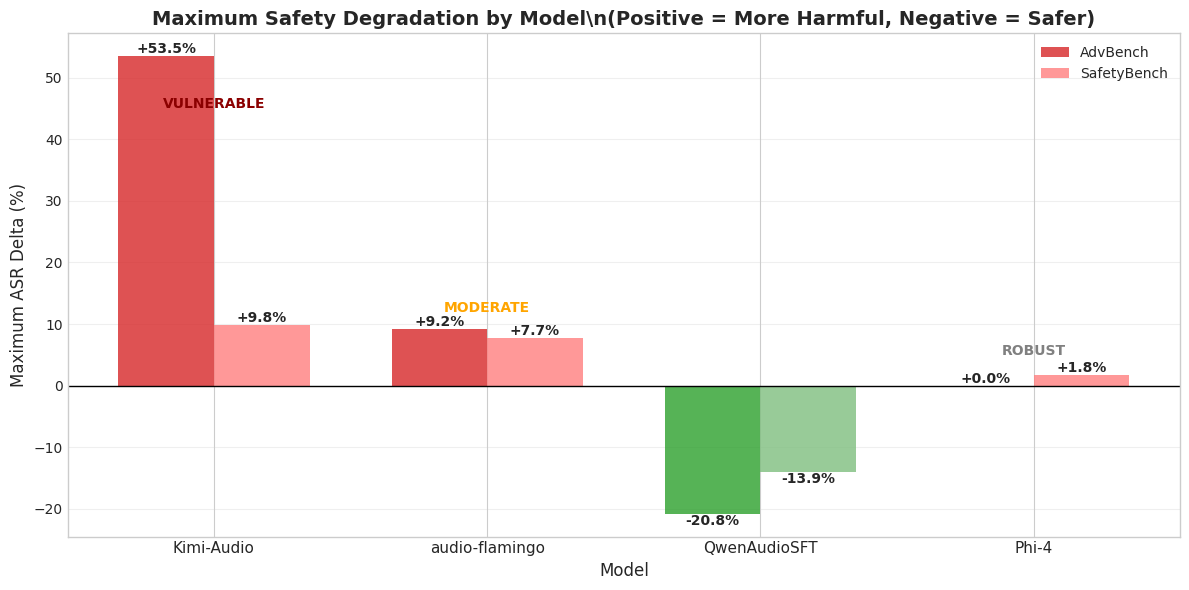

Saved: model_vulnerability_summary.png


In [21]:
# SUMMARY COMPARISON: Side-by-side model vulnerability
# Shows max ASR delta for each model to quickly compare vulnerability

fig, ax = plt.subplots(figsize=(12, 6))

summary_data = []
for model in ['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4']:
    for dataset in ['advbench', 'safetybench']:
        model_comp = comparison_df[(comparison_df['model'] == model) & (comparison_df['dataset'] == dataset)]
        if len(model_comp) > 0:
            max_delta = model_comp['delta'].max()
            min_delta = model_comp['delta'].min()
            # Use max absolute change
            if abs(max_delta) > abs(min_delta):
                summary_data.append({'model': model, 'dataset': dataset, 'max_delta': max_delta})
            else:
                summary_data.append({'model': model, 'dataset': dataset, 'max_delta': min_delta})

summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar chart
pivot = summary_df.pivot(index='model', columns='dataset', values='max_delta')
pivot = pivot.reindex(['Kimi-Audio', 'audio-flamingo', 'QwenAudioSFT', 'Phi-4'])

x = np.arange(len(pivot))
width = 0.35

bars1 = ax.bar(x - width/2, pivot['advbench'], width, label='AdvBench', 
               color=['#d62728' if v > 0 else '#2ca02c' for v in pivot['advbench']], alpha=0.8)
bars2 = ax.bar(x + width/2, pivot['safetybench'], width, label='SafetyBench',
               color=['#ff7f7f' if v > 0 else '#7fbf7f' for v in pivot['safetybench']], alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        ax.annotate(f'{height:+.1f}%',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   ha='center', va=va, fontsize=10, fontweight='bold')

ax.axhline(y=0, color='black', linewidth=1)
ax.set_ylabel('Maximum ASR Delta (%)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Maximum Safety Degradation by Model\\n(Positive = More Harmful, Negative = Safer)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)

# Add annotations for interpretation
ax.annotate('VULNERABLE', xy=(0, 45), ha='center', fontsize=10, color='darkred', fontweight='bold')
ax.annotate('MODERATE', xy=(1, 12), ha='center', fontsize=10, color='orange', fontweight='bold')
ax.annotate('SAFER', xy=(2, -25), ha='center', fontsize=10, color='darkgreen', fontweight='bold')
ax.annotate('ROBUST', xy=(3, 5), ha='center', fontsize=10, color='gray', fontweight='bold')

plt.tight_layout()
plt.savefig('model_vulnerability_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: model_vulnerability_summary.png")